#### **NEM Review contract co-design workshop**

# Contract financial performance modelling

## Prepare environment

In [1]:
# Data handling
import geopandas as gpd
import numpy as np
import os
import pandas as pd
import pyarrow.compute as pc

# Visualisation
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Custom functions
from scripts.common_functions import python_setup, get_mms_data, save_figure

# Set up Python
working_dir, charts_dir, data_dir = python_setup(2)

## Prepare data

### Access generators from latest Generation Information

In [2]:
# Check if generator details exist
gen_info_exist = os.path.exists(os.path.join(data_dir, "gen_info.csv"))

if not gen_info_exist:
    print("Generator information not found. Building dataset ...")

    # Check if source Excel file exists
    excel_path = os.path.join(data_dir, "external_sources", "AEMO_GenInfo_July_2025.xlsx")
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"AEMO source file not found at: {excel_path}")

    try:
        # Load generator details
        gen_info = pd.read_excel(
            excel_path,
            sheet_name=4,
            usecols=["Region", "Asset Type", "Site Name", "Fuel Type", "DUID"],
            header=1,
        ).rename(columns={
            "Asset Type": "Existing",
            "Site Name": "Name",
            "Fuel Type": "Technology"})
    
        # Filter gen info
        gen_info = gen_info[
            gen_info["Region"].isin(["NSW1", "QLD1", "SA1", "VIC1"]) &
            (gen_info["Existing"] == "Existing Plant") &
            gen_info["Technology"].isin(["Solar - Solar", "Wind - Wind"])
        ].iloc[:, [0, 4, 2, 3]]  # Select only needed columns

        # Format gen info
        gen_info = gen_info.replace({
            "Region": {"NSW1": "NSW", "QLD1": "QLD", "SA1": "SA", "VIC1": "VIC"},
            "Technology": {"Solar - Solar": "Solar", "Wind - Wind": "Wind"}
        })
        gen_info["DUID"] = gen_info["DUID"].str.strip().str.upper()

        # Drop duplicate DUIDs
        initial_count = len(gen_info)
        gen_info.drop_duplicates(subset="DUID", inplace=True)
        gen_info.dropna(subset=["DUID"], inplace=True)
        gen_info = gen_info[gen_info["DUID"] != "-"]
        final_count = len(gen_info)
        if initial_count != final_count:
            print(f"Warning: Dropped {initial_count - final_count} duplicate and null DUIDs")

        # Set index and check for empty DataFrame
        gen_info.set_index("DUID", inplace=True)
        if gen_info.empty:
            raise ValueError("No generator information found after filtering")

        print(f"Loaded {len(gen_info)} generators from AEMO file.")

    except Exception as e:
        print(f"Error loading generator information: {e}")
        raise

else:
    print("Generator information found. Dataset loaded.")
    try:
        gen_info = pd.read_csv(
            os.path.join(data_dir, "gen_info.csv"),
            index_col="DUID"
        )
        print(f"Loaded {len(gen_info)} generators from existing file.")
    except Exception as e:
        print(f"Error loading saved generator information: {e}")
        raise

# Basic validation
if 'gen_info' not in locals() or gen_info.empty:
    raise ValueError("No generator information available")

# Display basic info
print(f"\nGenerator dataset summary:")
print(f"- Regions: {gen_info['Region'].unique()}")
print(f"- Technologies: {gen_info['Technology'].unique()}")
print(f"- Total generators: {len(gen_info)}")

Generator information found. Dataset loaded.
Loaded 178 generators from existing file.

Generator dataset summary:
- Regions: ['SA' 'VIC' 'NSW' 'QLD']
- Technologies: ['Solar' 'Wind']
- Total generators: 178


### Collect historic DUID data

If no data yet exists, execute SQL query to collect output, availability and maximum capacity data for each DUID.

In [3]:
# Check if DUID data exists
duid_data_path = os.path.join(data_dir, "duid_data.parquet")

if not os.path.exists(duid_data_path):
    # Initialise an empty list to collect all region data
    all_region_data = []

    # Process in batches by region
    batch_size = 10
    for region in gen_info["Region"].unique():
        region_data = []
        region_duids = gen_info[gen_info["Region"] == region].index.tolist()
        duid_batches = [region_duids[i:i + batch_size] for i in range(0, len(region_duids), batch_size)]

        # Collect DUID data from MMS
        for i, batch in enumerate(duid_batches):
            print(f"Processing {region} batch {i + 1} of {len(duid_batches)}", end="\r")
            df = get_mms_data(
                "collect_duid_data",
                arguments={
                    "start_date": "2020-01-01",
                    "end_date": "2024-12-31",
                    "duid_list": ",".join([f"'{d}'" for d in batch])})
            if df is not None:  # Check if query returned data
                region_data.append(df)

        print(f"Processing {region} batch data ... complete.")
        # Concatenate all batches for this region
        if region_data:  # Only concatenate if we got data
            region_df = pd.concat(region_data)
            all_region_data.append(region_df)

    # Combine all region data
    if all_region_data:  # Only proceed if we got data
        duid_data = pd.concat(all_region_data)

        # Filter out empty DUIDs (DUIDs with no data)
        valid_duids = duid_data["DUID"].unique()
        gen_info = gen_info.loc[valid_duids]

        # Add maximum capacity values (latest value for each DUID)
        def get_latest_capacity(duid):
            duid_records = duid_data[duid_data["DUID"] == duid]
            if not duid_records.empty:
                return duid_records.sort_values("Interval").iloc[-1]["Maximum capacity"]
            return np.nan

        gen_info["Maximum capacity"] = gen_info.index.map(get_latest_capacity)

        # Add generator start time flag
        def is_late_starter(duid):
            duid_records = duid_data[duid_data["DUID"] == duid]
            start = pd.to_datetime("2020-01-01 00:00")
            if not duid_records.empty:
                return duid_records.iloc[0]["Interval"] > start
            return pd.isna(duid_records.iloc[0]["Maximum capacity"])

        gen_info["Late start"] = gen_info.index.map(is_late_starter)

        # Save amended gen info
        print("Saving generator information ...", end="\r")
        os.makedirs(data_dir, exist_ok=True)  # Ensure directory exists
        gen_info.to_csv(os.path.join(data_dir, "gen_info.csv"))
        print("Saving generator information ... complete.")

        # Save DUID data
        print("Saving DUID data ...", end="\r")
        os.makedirs(duid_data_path, exist_ok=True)  # Ensure directory exists
        duid_data.to_parquet(
            duid_data_path,
            engine="pyarrow",
            compression="snappy",
            index=False)
        print("Saving DUID data ... complete.")

else:
    print("Loading DUID generation data ...", end="\r")
    try:
        duid_data = pd.read_parquet(
            duid_data_path)
        print(f"Loaded DUID generation data from existing file.")
    except Exception as e:
        print(f"Error loading saved generator information: {e}")
        raise

# Count DUIDs used in analysis
if "duid_data" in locals():  # Only if we collected data    
    duid_counts = gen_info[gen_info["Late start"] == False].reset_index().pivot_table(
        index="Region",
        columns="Technology",
        values="DUID",
        aggfunc="count",
        fill_value=0).astype(int)
    print("\nDUID counts by region and technology:")
    print(duid_counts)

# Remove from memory
del duid_data

Loaded DUID generation data from existing file.

DUID counts by region and technology:
Technology  Solar  Wind
Region                 
NSW            12    10
QLD            19     2
SA              3    16
VIC             5    11


### Collect whole-of-market data

If no data yet exists, execute SQL query to collect SA prices and total demand data.

In [4]:
# Demand and prices path
demand_and_prices_path = os.path.join(data_dir, "demand_and_prices.parquet")

# Check if file exists
if not os.path.exists(demand_and_prices_path):
    print("demand_and_prices.parquet not found. Querying database ...")

    # Get generation and price data
    demand_and_prices = get_mms_data(
        script_name="collect_demand_and_prices",
        arguments={
            "start_date": "2020-01-01",
            "end_date": "2024-12-31"})

    # Save data to file
    demand_and_prices.to_parquet(
        demand_and_prices_path,
        engine="pyarrow",
        compression="snappy",
        index=False)
    print(f"Data saved.")

    # Remove from memory
    del demand_and_prices

## Wind and solar market observations

Calculate and visualise metrics of:
* Size of the wind and solar fleets over time (2020 to 2024)
* Locations of generators
* Capacity factors of generators
* Seasonal shape of generation and load
* Intraday shape of generation and load
* Demand-weighted prices for each region by wind, solar and region-wide

### Size of wind and solar fleets

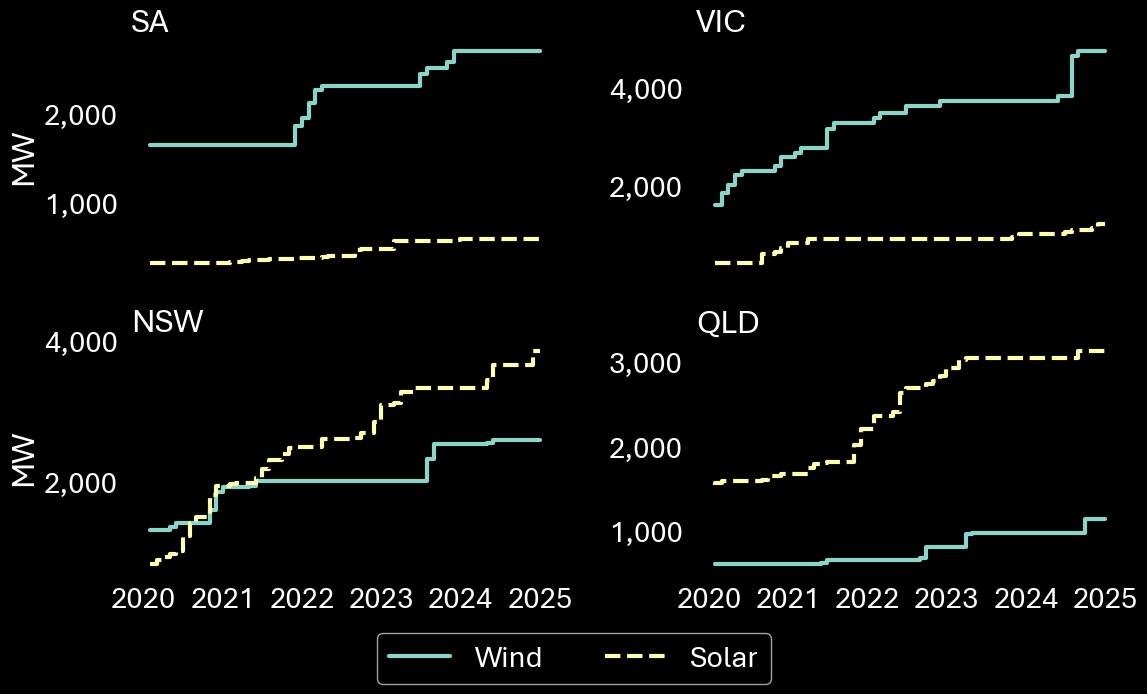

In [33]:
# Plot fleet sizes over time
fig, ax = plt.subplots(
    2, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharex=True)

for i, region in enumerate(gen_info["Region"].unique()):    
    # Prepare data
    region_duids = gen_info[gen_info["Region"] == region].index.tolist()
    region_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["Interval", "DUID", "Maximum capacity"])
    # Attach 'technology' to DUID data    
    region_duid_data["Technology"] = gen_info.loc[
        region_duid_data["DUID"],
        "Technology"].values

    # Aggregate to monthly
    chart_data = region_duid_data.pivot_table(
        index="Interval",
        columns="Technology",
        values="Maximum capacity",
        aggfunc="sum").resample("ME").mean()
    del region_duid_data

    # Save data to file
    chart_data.to_csv(
        os.path.join(data_dir, f"{region}_growth_of_fleet.csv"))

    # Plot in subplot
    axis = ax[i // 2, i % 2]
    for j, tech in enumerate(["Wind", "Solar"]):
        axis.step(
            x=chart_data.index,
            y=chart_data[tech],
            where="pre",
            linewidth=3,
            color=f"C{j}",
            label=tech,
            linestyle=["-", "--"][j])
    axis.set_xlabel(None)
    axis.set_ylabel("MW" if i % 2 == 0 else None)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.set_title(region, loc="left")
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    handles, labels = axis.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=2)
plt.show()
save_figure(fig, "growth_of_fleet", charts_dir)
del chart_data

### Generator capacity factors

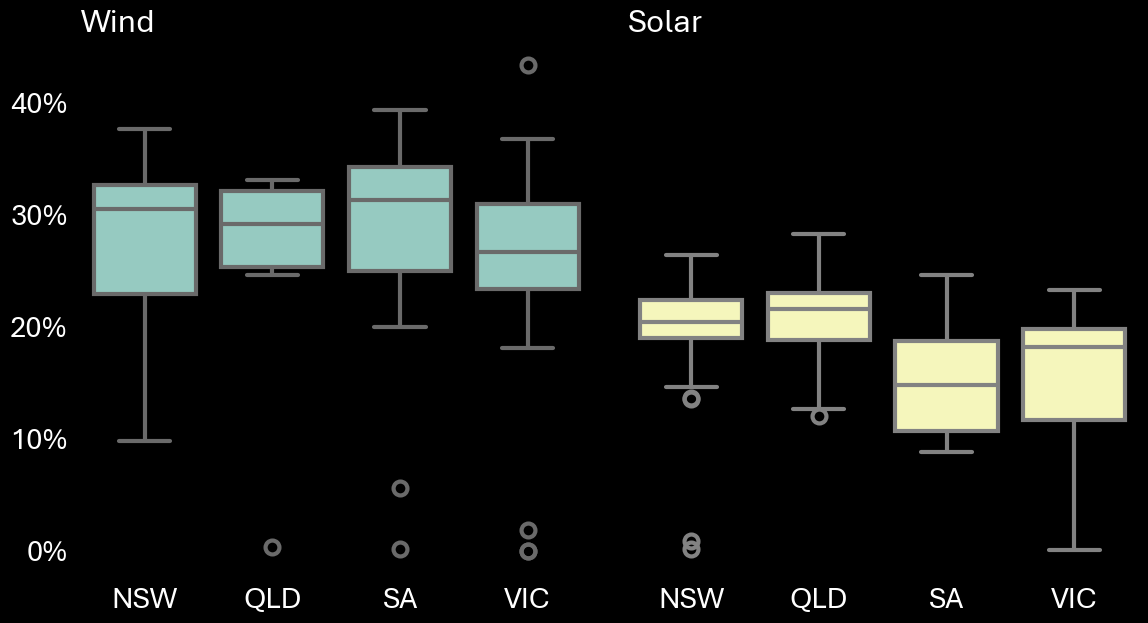

Aggregate fleet capacity factors:
      Wind  Solar
NSW  29.4%  20.9%
QLD  30.3%  20.6%
SA   30.6%  19.4%
VIC  26.7%  18.8%


In [16]:
# Plot fleet capacity factors
fig, ax = plt.subplots(
    1, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharex=True,
    sharey=True)

# Calculate aggregate CFs
aggregate_cfs = pd.DataFrame(
    columns=["Wind", "Solar"],
    index=["NSW", "QLD", "SA", "VIC"])

for i, tech in enumerate(["Wind", "Solar"]):
    # Prepare data
    tech_duids = gen_info[gen_info["Technology"] == tech].index.tolist()    
    tech_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", tech_duids)],
        columns=["DUID", "Output", "Maximum capacity"])
    # Attach 'technology' to DUID data
    tech_duid_data["Region"] = gen_info.loc[
        tech_duid_data["DUID"],
        "Region"].values
    tech_duid_data["Relative output"] = tech_duid_data["Output"] / tech_duid_data["Maximum capacity"]
    
    # Calculate CFs
    cf_pivot = tech_duid_data.pivot_table(
        index="DUID",
        columns="Region",
        values="Relative output",
        aggfunc="mean")
    capacity_factors = cf_pivot.reset_index().melt(
        id_vars="DUID",
        var_name="Region",
        value_name="Capacity factor").dropna()
    # Save CFs
    capacity_factors.to_csv(
        os.path.join(data_dir, f"{tech}_capacity_factors.csv"),
        index=False)

    # Calculate aggregate CF
    tech_cf = tech_duid_data.pivot_table(
        index="Region",
        values=["Output", "Maximum capacity"],
        aggfunc="sum")
    tech_cf["Capacity factor"] = tech_cf["Output"] / tech_cf["Maximum capacity"]
    for region in tech_cf.index:
        aggregate_cfs.at[region, tech] = tech_cf.at[region, "Capacity factor"]
    del tech_cf, tech_duid_data

    # Plot in subplot
    axis = ax[i]
    sns.boxplot(
        data=capacity_factors,
        x="Region",
        y="Capacity factor",
        color=f"C{i}",
        linewidth=3,
        fliersize=10,
        flierprops=dict(
            markeredgewidth=3),
        ax=axis)
    axis.set_xlabel(None)
    axis.set_ylabel(None)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0%}")
    axis.set_title(tech, loc="left")
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)

plt.show()
save_figure(fig, "fleet_capacity_factors", charts_dir)

print("Aggregate fleet capacity factors:")
print(aggregate_cfs.map(lambda x: f"{x:.1%}"))

### Generator locations

In [ ]:
# # Load states shapefile
# states = gpd.read_file(
#     os.path.join(data_dir, "australian_states_map.zip"))

# # Convert DUIDs to GeoDataFrame
# sa_gen_geo = gpd.GeoDataFrame(
#     sa_gen_info,
#     geometry=gpd.points_from_xy(
#         sa_gen_info.Longitude,
#         sa_gen_info.Latitude,
#         crs=states.crs))

# # Plot states outline
# marker_sizes = np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi)
# fig, ax = plt.subplots(
#     figsize=(12, 12),
#     tight_layout=True)
# sa_gen_geo.plot(
#     "Technology",
#     cmap=mpl.colors.ListedColormap(["C1", "C0"]),
#     markersize=(
#         (np.sqrt(sa_gen_geo["Maximum capacity"] / np.pi) - marker_sizes.min()) / 
#         (marker_sizes.max() - marker_sizes.min()) * 500 + 25),
#     alpha=.75,
#     edgecolor="white",
#     ax=ax,
#     legend=True)
# limits = ax.get_xlim(), ax.get_ylim()
# states.boundary.plot(
#     color="silver",
#     linestyle="--",
#     ax=ax)
# plt.xlim(limits[0][0], limits[0][1])
# plt.ylim(limits[1][0], limits[1][1])
# ax.set_axis_off()
# plt.show()
# save_figure(fig, "sa_generator_locations", charts_dir)

### Seasonal shape of generation and load

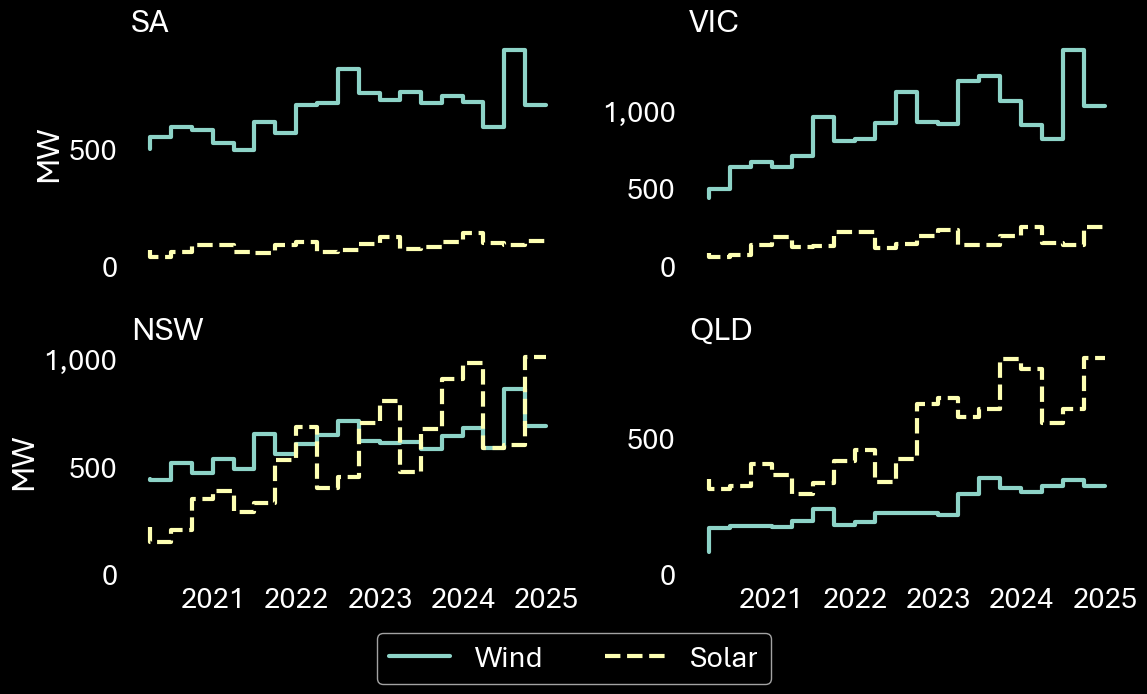

In [41]:
# Plot generation over time
fig, ax = plt.subplots(
    2, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharex=True)

for i, region in enumerate(gen_info["Region"].unique()):    
    # Prepare generation data
    region_duids = gen_info[gen_info["Region"] == region].index.tolist()
    region_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["DUID", "Interval", "Output"])
    # Attach 'technology' to DUID data
    region_duid_data["Technology"] = gen_info.loc[
        region_duid_data["DUID"],
        "Technology"].values

    # Aggregate to quarterly
    chart_data = region_duid_data.pivot_table(
        index="Interval",
        columns="Technology",
        values="Output",
        aggfunc="sum").resample("QE").mean()
    chart_data.index.name = "Quarter"
    del region_duid_data

    # Save data to file
    chart_data.to_csv(
        os.path.join(data_dir, f"{region}_mean_quarterly_generation.csv"))

    # Plot in subplot
    axis = ax[i // 2, i % 2]
    for j, tech in enumerate(["Wind", "Solar"]):
        axis.step(
            x=chart_data.index,
            y=chart_data[tech],
            where="pre",
            linewidth=3,
            color=f"C{j}",
            label=tech,
            linestyle=["-", "--"][j])
    axis.set_xlabel(None)
    axis.set_ylabel("MW" if i % 2 == 0 else None)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.set_title(region, loc="left")
    axis.set_ylim(0)
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    handles, labels = axis.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=2)
plt.show()
save_figure(fig, "mean_quarterly_generation", charts_dir)

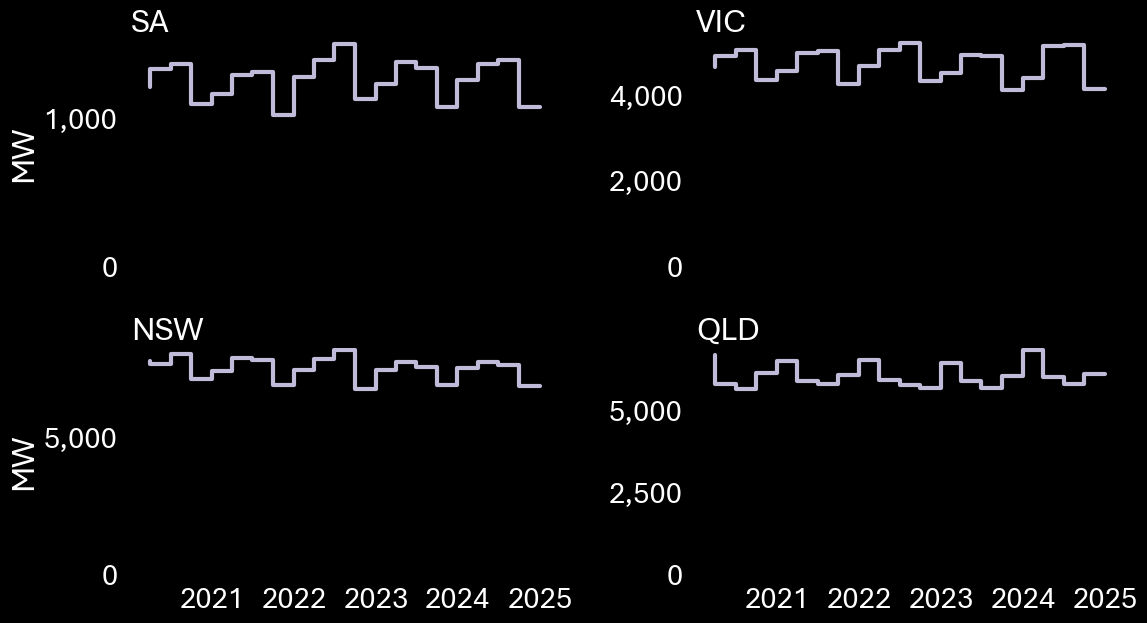

In [42]:
# Plot load over time
fig, ax = plt.subplots(
    2, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharex=True)

for i, region in enumerate(gen_info["Region"].unique()):    
    # Prepare load data    
    region_demand_data = pd.read_parquet(
        demand_and_prices_path,
        engine="pyarrow",
        filters=[("Region", "==", region)],
        columns=["Interval", "Total demand"]).set_index("Interval")

    # Aggregate to quarterly
    chart_data = region_demand_data.resample("QE").mean()
    chart_data.index.name = "Quarter"
    del region_demand_data

    # Save data to file
    chart_data.to_csv(
        os.path.join(data_dir, f"{region}_mean_quarterly_load.csv"))

    # Plot in subplot
    axis = ax[i // 2, i % 2]
    axis.step(
        x=chart_data.index,
        y=chart_data,
        where="pre",
        linewidth=3,
        color="C2")
    axis.set_xlabel(None)
    axis.set_ylabel("MW" if i % 2 == 0 else None)
    axis.set_ylim(0)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.set_title(region, loc="left")
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
plt.show()
save_figure(fig, "mean_quarterly_load", charts_dir)

### Intraday shape of generation and load

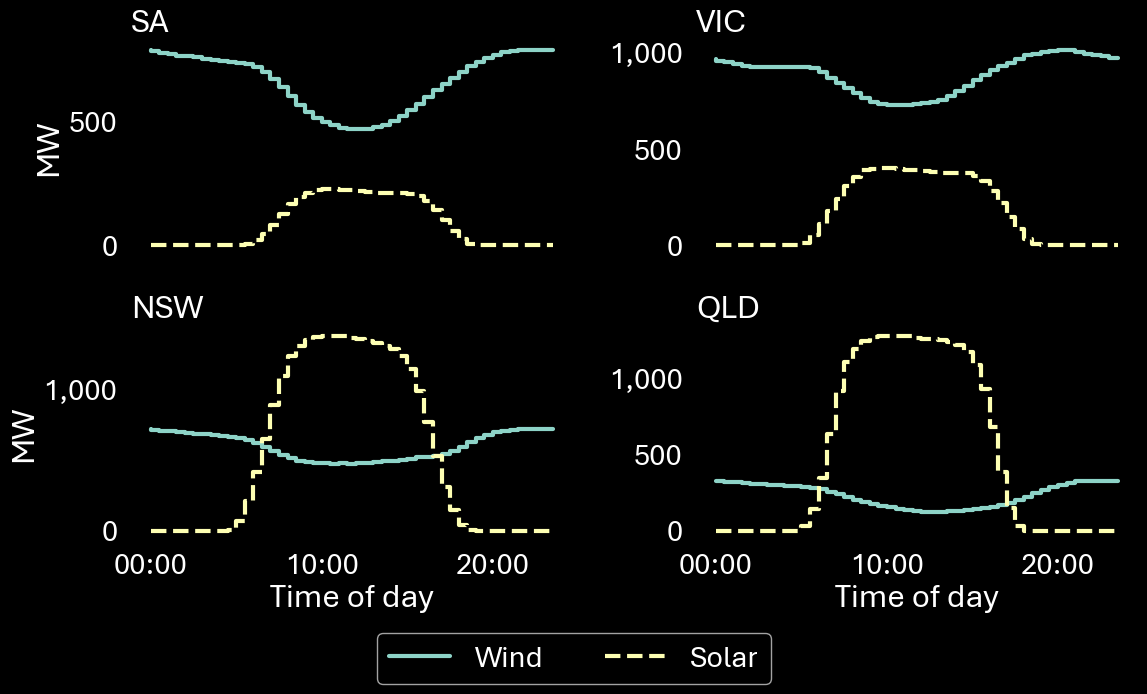

In [43]:
# Plot intraday generation
fig, ax = plt.subplots(
    2, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharex=True)

for i, region in enumerate(gen_info["Region"].unique()):    
    # Prepare generation data
    region_duids = gen_info[gen_info["Region"] == region].index.tolist()
    region_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["DUID", "Interval", "Output"])
    # Attach 'technology' to DUID data
    region_duid_data["Technology"] = gen_info.loc[
        region_duid_data["DUID"],
        "Technology"].values

    # Calculate intraday averages
    chart_data = region_duid_data.pivot_table(
        index="Interval",
        columns="Technology",
        values="Output",
        aggfunc="sum")
    chart_data["30-min interval"] = chart_data.index.hour * 2 + chart_data.index.minute // 30
    chart_data = chart_data.pivot_table(
        index="30-min interval",
        values=["Wind", "Solar"],
        aggfunc="mean")
    chart_data.index.name = "Time of day"
    del region_duid_data

    # Save data to file
    chart_data.to_csv(
        os.path.join(data_dir, f"{region}_mean_intraday_generation.csv"))

    # Plot in subplot
    axis = ax[i // 2, i % 2]
    for j, tech in enumerate(["Wind", "Solar"]):
        axis.step(
            x=chart_data.index,
            y=chart_data[tech],
            where="pre",
            linewidth=3,
            color=f"C{j}",
            label=tech,
            linestyle=["-", "--"][j])
    axis.set_xlabel("Time of day" if i // 2 == 1 else None)
    axis.set_ylabel("MW" if i % 2 == 0 else None)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.xaxis.set_major_formatter(lambda x, p: f"{pd.to_datetime('2025-01-01') + pd.DateOffset(minutes=x * 30):%H:%M}")
    axis.set_title(region, loc="left")
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    handles, labels = axis.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=2)
plt.show()
save_figure(fig, "mean_intraday_generation", charts_dir)

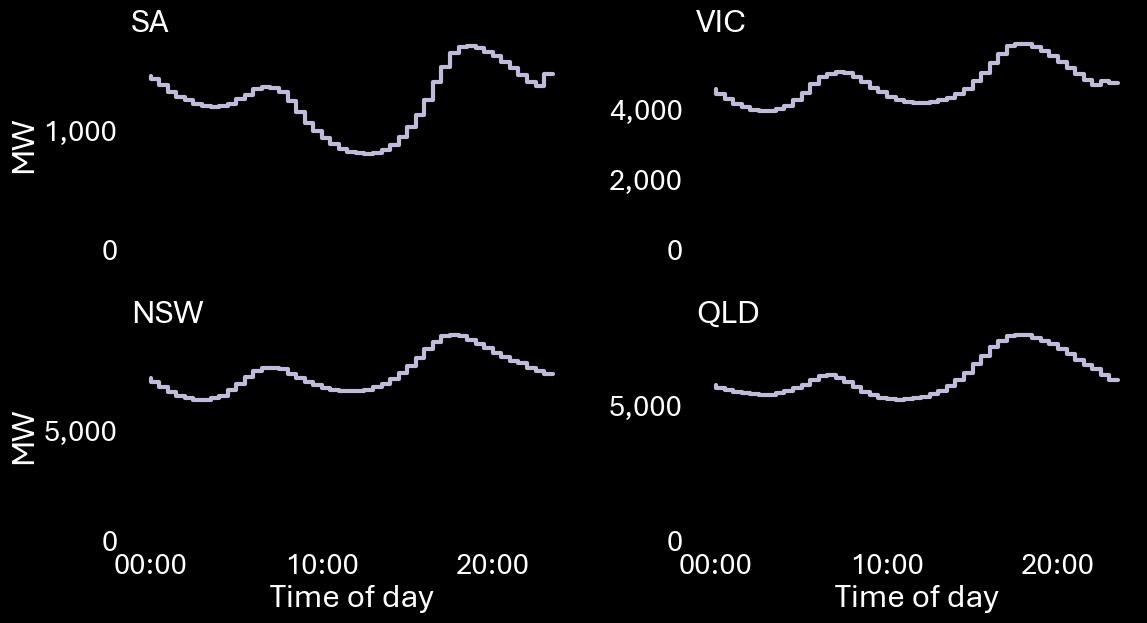

In [46]:
# Plot intraday load
fig, ax = plt.subplots(
    2, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharex=True)

for i, region in enumerate(gen_info["Region"].unique()):    
    # Prepare load data    
    region_demand_data = pd.read_parquet(
        demand_and_prices_path,
        engine="pyarrow",
        filters=[("Region", "==", region)],
        columns=["Interval", "Total demand"]).set_index("Interval")

    # Calculate intraday averages
    region_demand_data["30-min interval"] = region_demand_data.index.hour * 2 + region_demand_data.index.minute // 30    
    chart_data = region_demand_data.pivot_table(
        index="30-min interval",
        aggfunc="mean")
    chart_data.index.name = "Time of day"
    del region_demand_data

    # Save data to file
    chart_data.to_csv(
        os.path.join(data_dir, f"{region}_mean_intraday_load.csv"))

    # Plot in subplot
    axis = ax[i // 2, i % 2]
    axis.step(
        x=chart_data.index,
        y=chart_data,
        where="pre",
        linewidth=3,
        color="C2")
    axis.set_ylim(0)
    axis.set_xlabel("Time of day" if i // 2 == 1 else None)
    axis.set_ylabel("MW" if i % 2 == 0 else None)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.xaxis.set_major_formatter(lambda x, p: f"{pd.to_datetime('2025-01-01') + pd.DateOffset(minutes=x * 30):%H:%M}")
    axis.set_title(region, loc="left")
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
plt.show()
save_figure(fig, "mean_intraday_load", charts_dir)

### Volume-weighted average prices: market, wind and solar

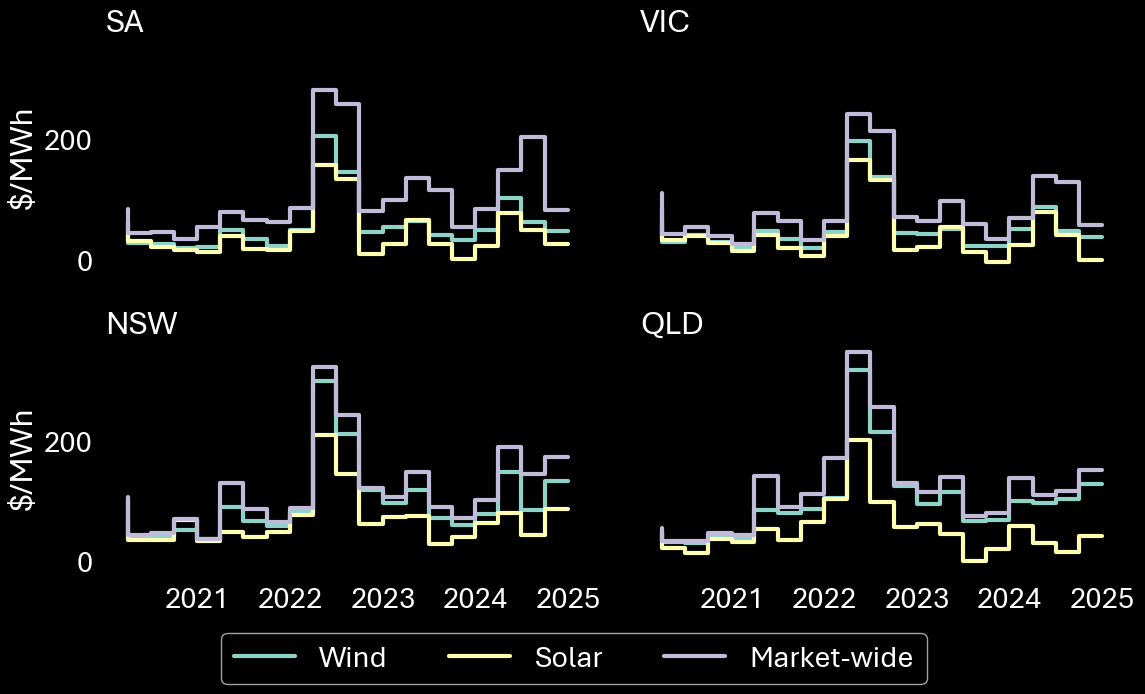

In [50]:
# Plot VWA prices
fig, ax = plt.subplots(
    2, 2,
    figsize=(12, 6.75),
    tight_layout=True,
    sharey=True,
    sharex=True)

for i, region in enumerate(gen_info["Region"].unique()):    
    # Prepare DUID data    
    region_duids = gen_info[gen_info["Region"] == region].index.tolist()
    region_duid_data = pd.read_parquet(
        duid_data_path,
        engine="pyarrow",
        filters=[("DUID", "in", region_duids)],
        columns=["DUID", "Interval", "Output"])
    # Attach 'technology' to DUID data
    region_duid_data["Technology"] = gen_info.loc[
        region_duid_data["DUID"],
        "Technology"].values
    # Prepare market data
    region_market_data = pd.read_parquet(
        demand_and_prices_path,
        engine="pyarrow",
        filters=[("Region", "==", region)],
        columns=["Interval", "Total demand", "Price"]).set_index("Interval")

    # Prepare volume-weighted price data
    region_market_data["Revenue"] = region_market_data["Total demand"] * region_market_data["Price"]

    # Merge price and generation data
    chart_data = region_duid_data.pivot_table(
        index="Interval",
        columns="Technology",
        values="Output",
        aggfunc="sum")
    chart_data["Price"] = region_market_data["Price"]
    chart_data["Solar revenue"] = chart_data["Solar"] * chart_data["Price"]
    chart_data["Wind revenue"] = chart_data["Wind"] * chart_data["Price"]

    # Calculate quarterly prices
    lwa_prices = region_market_data.resample("QE")[["Total demand", "Revenue"]].sum()
    lwa_prices.index.name = "Quarter"
    dwa_prices_solar = chart_data.resample("QE")[["Solar", "Solar revenue"]].sum()
    dwa_prices_solar.index.name = "Quarter"
    dwa_prices_wind = chart_data.resample("QE")[["Wind", "Wind revenue"]].sum()
    dwa_prices_wind.index.name = "Quarter"
    lwa_prices["LWA price"] = lwa_prices["Revenue"] / lwa_prices["Total demand"]
    dwa_prices_solar["DWA price"] = dwa_prices_solar["Solar revenue"] / dwa_prices_solar["Solar"]
    dwa_prices_wind["DWA price"] = dwa_prices_wind["Wind revenue"] / dwa_prices_wind["Wind"]
    # Save to file
    lwa_prices.iloc[:, -1:].to_csv(
        os.path.join(data_dir, f"{region}_dwa_prices_quarterly.csv"))
    dwa_prices_solar.iloc[:, -1:].to_csv(
        os.path.join(data_dir, f"{region}_dwa_solar_prices_quarterly.csv"))
    dwa_prices_wind.iloc[:, -1:].to_csv(
        os.path.join(data_dir, f"{region}_dwa_wind_prices_quarterly.csv"))

    # Plot prices
    axis = ax[i // 2, i % 2]
    axis.step(
        x=dwa_prices_wind.index,
        y=dwa_prices_wind["DWA price"],
        where="pre",
        linewidth=3,
        color="C0",
        label="Wind")
    axis.step(
        x=dwa_prices_solar.index,
        y=dwa_prices_solar["DWA price"],
        where="pre",
        linewidth=3,
        color="C1",
        label="Solar")
    axis.step(
        x=lwa_prices.index,
        y=lwa_prices["LWA price"],
        where="pre",
        linewidth=3,
        color="C2",
        label="Market-wide")
    axis.set_xlabel(None)
    axis.set_ylabel("$/MWh" if i % 2 == 0 else None)
    axis.yaxis.set_major_formatter(lambda x, p: f"{x:,.0f}")
    axis.set_title(region, loc="left")
    for frame in ["top", "right", "bottom", "left"]:
        axis.spines[frame].set_visible(False)
    handles, labels = axis.get_legend_handles_labels()
fig.legend(handles=handles, loc="lower center", bbox_to_anchor=(0.5, -0.075), ncol=3)
plt.show()
save_figure(fig, "vwa_prices_quarterly", charts_dir)